## Quotations indicate the career success of public figures
**ChillDataGroup: Zihan Wu, Yinhao Wang, Yihang Chen**

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

## Load QuoteBank Dataset
We refer to the pipeline provided in Google Colab to load the quotations from 2015 to 2020.

Due to the large size of data, when loading them, we just load the data said by the senate election since 2015 candidates. The dataset for senate elections is obtained from MIT Election Data and Science Lab [1].

We also provide the codes for loading these senate candidate quotations below, but those are run ahead in google colab (takes around 30min for each year's data). We did not re-run them here. It contains the senate election results for all candidates

[1] MIT Election Data and Science Lab, 2017, "U.S. Senate 1976–2020", https://doi.org/10.7910/DVN/PEJ5QU, Harvard Dataverse, V5.

In [2]:
# Pipeline obtained from the course google colab
from tld import get_tld

def get_domain(url):
    res = get_tld(url, as_object=True)
    return res.tld

In [3]:
# Load the Senate Election Result data 
import pandas as pd
senate_file = 'SenateData/1976-2020-senate.csv'
senate_election = pd.read_csv(senate_file, encoding= 'unicode_escape')
senate_election.sample(4) # demonstrate the format of election data

,year,state,state_po,state_fips,state_cen,state_ic,office,district,stage,special,candidate,party_detailed,writein,mode,candidatevotes,totalvotes,unofficial,version,party_simplified
2487,2010,CONNECTICUT,CT,9,16,1,US SENATE,statewide,gen,False,LINDA E. MCMAHON,REPUBLICAN,False,total,498341,1153115,False,20210114,REPUBLICAN
3423,2020,ALABAMA,AL,1,63,41,US SENATE,statewide,gen,False,NaN,NaN,True,total,3891,2316445,False,20210114,OTHER
1053,1992,HAWAII,HI,15,95,82,US SENATE,statewide,gen,False,LINDA B. MARTIN,GREEN,False,total,49921,363662,False,20210114,OTHER
1505,1998,COLORADO,CO,8,84,62,US SENATE,statewide,gen,False,BEN NIGHTHORSE CAMPBELL,REPUBLICAN,False,total,829370,1327235,False,20210114,REPUBLICAN


Here, we only choose the candidate running for elections since 2016, because the supported Quotebank data goes back to 2015

In [4]:
# Load the names of candidates since 2016
# The NaN names are dropped, and repeated names are dropped
def delete_middle_name(name): # delete middle name
  name_split = name.upper().split()
  if len(name_split) > 2:
    senate_delete_middle_name = name_split[0] + ' ' + name_split[-1]
    return senate_delete_middle_name
  return name

# To address the variation of names, we use this function to determine whether the speaker name matches the first and 
# last name of any senate candidates. In this way, we can find speakers with different name writing style like:
# 'Senate Lindsey Graham', 'Lindsey Olin Graham', 'Lindsey O. Graham' (they all indicate the same candidate)

# The function below takes in a speaker name and a list of senate names (already split into first and last name)
# It returns a boolean whether the speaker is a senate, and the name of senate (in the form of first + last name) if true
def isSenate(name,senate_names):
  name_set = set(name.upper().split())
  for i in range(len(senate_names)):
    if senate_names[i] <= name_set:
      return (True, i)
  return (False, None)

senate_candidates = senate_election[senate_election['year'] >= 2016].dropna(subset=['candidate', 'party_detailed'])['candidate'].unique()
senate_candidates_splitted = list(map(lambda senate: set(delete_middle_name(senate).split()), senate_candidates))
senate_candidates_splitted[1:10]

[{'RICHARD', 'SHELBY'},
 {'JOE', 'MILLER'},
 {'GIANOUTSOS', 'TED'},
 {'METCALFE', 'RAY'},
 {'MARGARET', 'STOCK'},
 {'BRECK', 'CRAIG'},
 {'LISA', 'MURKOWSKI'},
 {'ANTHONY', 'CAMBONI'},
 {'ANN', 'KIRKPATRICK'}]

In [5]:
#Sanity Check: all names at least have a first and last name
for split in senate_candidates_splitted:
    assert(len(split) > 1)
print('there are total {} names'.format(len(senate_candidates_splitted)))

there are total 439 names


**We do not run the cell below because takes too long.** We have run those on google colab to load the quotation data we need

In [ ]:
%%script echo skipping
# Load each year's data, filtering out the quotations said by senates
# We have considered the different writing styles of name. We extract the quote as long as the speaker has the same
# first name and last name as a senate
import bz2
import json

path_to_file = '/content/drive/MyDrive/Quotebank/quotes-{}.json.bz2' 
path_to_out = '/content/drive/MyDrive/MyQuoteBank/quotes-{}-senates-said.json.bz2'

for year in range(2015, 2021):
  print('... Start reading quotations in year ' + str(year))
  with bz2.open(path_to_file.format(year), 'rb') as s_file:
      with bz2.open(path_to_out.format(year), 'wb') as d_file:
          for instance in s_file:
              instance = json.loads(instance) # loading a sample
              issenate = isSenate(instance['speaker'], senate_candidates_splitted)
              if issenate[0]:
                instance['speaker'] = senate_candidates[issenate[1]] # use name from the "1976-2020-senate.csv" as the standard name.
                urls = instance['urls'] # extracting list of links
                domains = []
                for url in urls:
                    tld = get_domain(url)
                    domains.append(tld)
                instance['domains'] = domains # updating the sample with domain name
                d_file.write((json.dumps(instance)+'\n').encode('utf-8')) # writing in the new file

# Load each year's data, filtering out the quotations that mention senates
path_to_file = '/content/drive/MyDrive/Quotebank/quotes-{}.json.bz2'
path_to_out = '/content/drive/MyDrive/ADAQuoteBank/quotes-{}-senates-mention.json.bz2'

senate_candidates = list(map(lambda x:x.title(), senate_candidates))

for year in range(2016,2021):
    print('... Start processing quotations in year {}'.format(year))
    with bz2.open(path_to_file.format(year), 'rb') as s_file:
        with bz2.open(path_to_out.format(year), 'wb') as d_file:
            for instance in s_file:
                instance = json.loads(instance)
                is_senate = isSenate(instance['quotation'], senate_candidates_splitted)
                if is_senate[0]:
                    instance['mention']=senate_candidates[is_senate[1]]
                    urls = instance['urls'] # extracting list of links
                    domains = []
                    for url in urls:
                        tld = get_domain(url)
                        domains.append(tld)
                    instance['domains'] = domains # updating the sample with domain name
                    d_file.write((json.dumps(instance)+'\n').encode('utf-8'))
    print('... End processing quotations in year {}'.format(year))

## 1. Process Senate Candidate Data
**1.1** In this section, we load the information of senate candidates (since 2016) and their election information.

In [6]:
# First, we get the election information of the candidates since 2016 (again, we drop NaN and repeated names)
candidate_info = senate_election[senate_election['year'] >= 2016].dropna(subset=['candidate', 'party_detailed']).drop_duplicates(subset=['candidate'], ignore_index=True)

In [7]:
# Load the stored quotations said by senate candidates since 2015 (by year)
senate_quote_20 = pd.read_json('SenateData/quotes-2020-senates-said.json.bz2', lines=True, compression='bz2')
senate_quote_19 = pd.read_json('SenateData/quotes-2019-senates-said.json.bz2', lines=True, compression='bz2')
senate_quote_18 = pd.read_json('SenateData/quotes-2018-senates-said.json.bz2', lines=True, compression='bz2')
senate_quote_17 = pd.read_json('SenateData/quotes-2017-senates-said.json.bz2', lines=True, compression='bz2')
senate_quote_16 = pd.read_json('SenateData/quotes-2016-senates-said.json.bz2', lines=True, compression='bz2')
senate_quote_15 = pd.read_json('SenateData/quotes-2015-senates-said.json.bz2', lines=True, compression='bz2')

In [8]:
# Concatenate data across all years and display the format of quotation data
annual_frames = [senate_quote_15, senate_quote_16, senate_quote_17, senate_quote_18, senate_quote_19, senate_quote_20]
candidate_quotes = pd.concat(annual_frames).reset_index()
candidate_quotes.sample(4)

,index,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,domains
666679,111737,2018-05-20-033493,"Just to put a point on this, still as far as t...",MARK R. WARNER,"[Q14949474, Q1617921, Q21166633, Q453893, Q512...",2018-05-20 14:22:57,1,"[[Mark Warner, 0.5092], [None, 0.2809], [Jake ...",[http://www.breitbart.com/video/2018/05/20/wat...,E,[com]
182636,182636,2015-07-28-009538,At one point or another we would have just par...,LISA MURKOWSKI,[Q22360],2015-07-28 16:51:44,1,"[[Lisa Murkowski, 0.824], [None, 0.1489], [Mar...",[http://thehill.com/policy/energy-environment/...,E,[com]
973069,164616,2019-10-02-028509,He will be resting up over the next couple of ...,BERNIE SANDERS,[Q359442],2019-10-02 15:19:52,1,"[[Bernie Sanders, 0.7543], [None, 0.2457]]",[https://www.theepochtimes.com/c-span-issues-c...,E,[com]
114860,114860,2015-08-22-039394,Now the Washington elites want to silence thos...,TED CRUZ,[Q2036942],2015-08-22 21:19:52,2,"[[Ted Cruz, 0.8254], [None, 0.1642], [Ellen Pa...",[http://www.rawstory.com/2015/08/iowa-gop-chai...,E,"[com, com]"


Since QuoteBank may extract different number of total quotes at different time. An increase in quotations may just be caused by an increase of quotes extracted by Quotebanks. So, we use the total quotation number in QuoteBank to normalize our data

In [9]:
# read the quote number data for each month

import csv
with open('SenateData/quote_num.csv','r') as inFile:
    reader = csv.DictReader(inFile)
    for row in reader:
        quote_num = dict(row)
quote_num = pd.Series({k:int(v) for k, v in quote_num.items()})
quote_num

2015-01    1661137
2015-02    1659518
2015-03    1867911
2015-04    1522315
2015-05    1136152
            ...   
2019-12    1565321
2020-01    1732238
2020-02    1599019
2020-03    1323347
2020-04     589845
Length: 64, dtype: int64

In [10]:
# we use 10^6/total_quote_num as normalize factor

candidate_quotes['normalize_factor'] = candidate_quotes['date'].map(lambda x: 1/quote_num[str(x)[:7]]*1e6)
candidate_quotes['normalize_quotes'] = candidate_quotes['numOccurrences']*candidate_quotes['normalize_factor']
candidate_quotes.sample(4)

,index,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,domains,normalize_factor,normalize_quotes
1086198,48968,2020-01-23-112135,"Well, you know what, they spent all of Tuesday...",MAZIE K. HIRONO,[Q16476],2020-01-23 17:43:50,1,"[[Mazie Hirono, 0.7282], [None, 0.1682], [Chuc...",[https://www.courthousenews.com/trump-prosecut...,E,[com],0.577288,0.577288
420335,105937,2017-07-11-058589,"It is very, very important that we deliver on ...",CHUCK GRASSLEY,[Q529294],2017-07-11 14:41:37,1,"[[Chuck Grassley, 0.9262], [None, 0.0697], [Ja...",[http://www.newsmax.com/Politics/chuck-grassle...,E,[com],0.418827,0.418827
1073451,36221,2020-02-23-005789,"doesn't hurt, obviously, because people, I thi...",MICHAEL F. BENNET,[Q554792],2020-02-23 01:50:05,2,"[[Michael Bennet, 0.7773], [None, 0.2227]]",[https://www.vaildaily.com/news/sen-michael-be...,E,"[com, com]",0.625383,1.250767
320895,6497,2017-07-26-092768,Nearly everyone agrees that doing nothing is n...,TODD C. YOUNG,[Q25483],2017-07-26 07:23:05,1,"[[Senator Todd Young, 0.9173], [None, 0.0827]]",[https://insurancenewsnet.com/oarticle/stateme...,E,[com],0.418827,0.418827


**1.2** We group the total number of quotations by speaker and dates. By doing so, we can visualize the change of quoted numbers as time goes on. Below, we take Bernie Sanders as an example.

In [11]:
# Clean the names by taking only upper case
# Group the candidate total number of normalized quotes by day
candidate_quotes['speaker'] = candidate_quotes['speaker'].str.upper()
candidate_quotes['date_only'] = candidate_quotes['date'].dt.date
candidate_quotes_byday = candidate_quotes.groupby(['speaker', 'date_only'])['normalize_quotes'].sum()
candidate_quotes_byday

speaker           date_only 
A. WAYNE JOHNSON  2015-01-06    0.601997
                  2015-02-09    0.602585
                  2015-02-11    1.205169
                  2015-02-20    0.602585
                  2015-03-01    0.535357
                                  ...   
ZAK RINGELSTEIN   2018-10-30    5.125275
                  2018-11-01    2.381878
                  2018-11-05    0.476376
                  2018-11-07    0.476376
                  2019-03-21    0.503878
Name: normalize_quotes, Length: 136070, dtype: float64

Text(0.5, 1.0, 'Bernie Sanders')

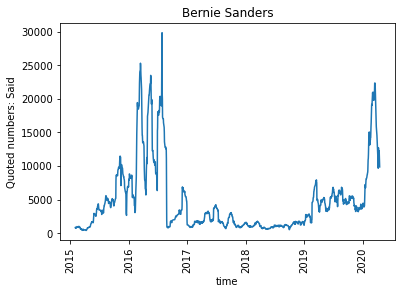

In [12]:
# For example, we can visualize the quotation changes of Bernie Sanders
candidate_quotes_byday['BERNIE SANDERS'].rolling(window=30).sum().plot() # one months average
plt.xlabel('time')
plt.xticks(rotation=90)
plt.ylabel('Quoted numbers: Said')
plt.title('Bernie Sanders')

**1.3** We compute the total number of quotations until their election. The election dataset only contains the year of election. However, since the U.S. Senate elections always take place in the first week of November, we just compute the total number of quotations until November.1st of the election year.

In [13]:
# Add the election day corresponding to each candidate speaker
candidate_info_byname = candidate_info.set_index(['candidate']) # Allow access info by name as index
candidate_quotes['election_day'] = candidate_quotes['speaker'].map(candidate_info_byname['year']).astype(str)+ '-11-01'
candidate_quotes['election_day'] = pd.to_datetime(candidate_quotes['election_day'])

In [14]:
# Add election result (i.e. vote rate) for each candidate speaker
candidate_info_byname['vote_rate'] = candidate_info_byname['candidatevotes']/candidate_info_byname['totalvotes']

In [15]:
# We group the number of quotations by election day
quotes_byelection = candidate_quotes[candidate_quotes['date_only'] < candidate_quotes['election_day']]
tot_quotes_byelection = pd.DataFrame(quotes_byelection.groupby(['speaker'])['normalize_quotes'].sum())
tot_quotes_byelection.rename(columns = {'normalize_quotes': 'total_quotes_byelection'}, inplace=True)

Pearson coefficient: 0.6112235983030404, p value: 3.506776291721492e-26


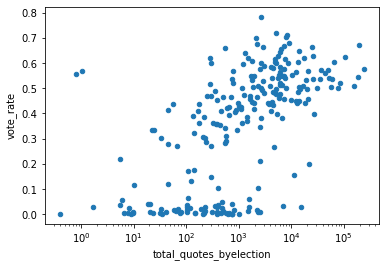

In [16]:
# We add the vote rate and plot the scatter plot of vote rate against total quotes by election
from scipy.stats import pearsonr
tot_quotes_byelection['vote_rate'] = tot_quotes_byelection.index.map(candidate_info_byname['vote_rate'])
quotes_vote = tot_quotes_byelection.plot.scatter(x = 'total_quotes_byelection', y = 'vote_rate', logx=True)
(corr1, pvalue) = pearsonr(np.log(tot_quotes_byelection['total_quotes_byelection']), tot_quotes_byelection['vote_rate'])
print(f'Pearson coefficient: {corr1}, p value: {pvalue}')

**Observation**: Based on the plot above, we can see that there is a positive correlation between quotations and vote_rate with p value < 0.05. The more a candidate was quoted before the election, the higher the voting rate he or she got.

**1.4** We can also apply the analysis on quotations that mention senates.

In [17]:
# Load the stored quotations mention senate candidates since 2015 (by year)
senate_quote_20_mention = pd.read_json('SenateData/quotes-2020-senates-mention.json.bz2', lines=True, compression='bz2')
senate_quote_19_mention = pd.read_json('SenateData/quotes-2019-senates-mention.json.bz2', lines=True, compression='bz2')
senate_quote_18_mention = pd.read_json('SenateData/quotes-2018-senates-mention.json.bz2', lines=True, compression='bz2')
senate_quote_17_mention = pd.read_json('SenateData/quotes-2017-senates-mention.json.bz2', lines=True, compression='bz2')
senate_quote_16_mention = pd.read_json('SenateData/quotes-2016-senates-mention.json.bz2', lines=True, compression='bz2')
senate_quote_15_mention = pd.read_json('SenateData/quotes-2015-senates-mention.json.bz2', lines=True, compression='bz2')

In [18]:
# Concatenate data across all years and display the format of quotation data
annual_frames_mention = [senate_quote_15_mention, senate_quote_16_mention, senate_quote_17_mention, senate_quote_18_mention, senate_quote_19_mention, senate_quote_20_mention]
candidate_quotes_mention = pd.concat(annual_frames_mention)
candidate_quotes_mention.sample(4)

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,mention,domains
4346,2015-03-24-069134,Ted Cruz has even less experience in American ...,Carl Cannon,"[Q21551439, Q48968491]",2015-03-24 12:07:13,1,"[[Carl Cannon, 0.6058], [None, 0.1123], [Ben D...",[http://blogs.wsj.com/washwire/2015/03/24/capi...,E,Ted Cruz,[com]
15663,2015-09-12-047672,That is asking Bernie Sanders to be very inaut...,Joy Williams,"[Q3187212, Q6297286]",2015-09-12 11:07:20,3,"[[Joy Williams, 0.602], [None, 0.3264], [Symon...",[http://www.salon.com/2015/09/12/black_voters_...,E,Bernie Sanders,"[com, com, com]"
12547,2017-10-14-051560,"Now, when it matters because you have a presid...",President Donald Trump,[Q22686],2017-10-14 15:42:24,3,"[[President Donald Trump, 0.6918], [None, 0.18...",[http://europe.newsweek.com/will-trump-start-c...,E,John Mccain,"[com, com, com]"
2547,2016-07-05-025559,"He's not going to deliver New Jersey, New Jers...",None,[],2016-07-05 18:26:41,2,"[[None, 0.5009], [Richard Davenport, 0.2192], ...",[http://app.com/story/news/politics/2016/07/05...,E,Elizabeth A. Warren,"[com, com]"


In [19]:
# format the date
candidate_quotes_mention['date_only'] = candidate_quotes_mention['date'].dt.date
# change the name to upper format
candidate_quotes_mention['mention'] = candidate_quotes_mention['mention'].str.upper()

# Normalize the quotes
candidate_quotes_mention['normalize_factor'] = candidate_quotes_mention['date'].map(lambda x: 1/quote_num[str(x)[:7]]*1e6)
candidate_quotes_mention['normalize_quotes'] = candidate_quotes_mention['numOccurrences']*candidate_quotes_mention['normalize_factor']
candidate_quotes_mention.sample(5)

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,mention,domains,date_only,normalize_factor,normalize_quotes
12936,2015-09-23-083070,Sen Bernie Sanders (I-Vt.) can't seem to hold ...,None,[],2015-09-23 21:17:48,1,"[[None, 0.3282], [BERNIE SANDERS, 0.2641], [HI...",[http://www.huffingtonpost.com/2015/09/23/huff...,E,BERNIE SANDERS,[com],2015-09-23,0.447555,0.447555
11994,2018-12-18-064737,Oh look. A supporter of Bernie Sanders attacki...,Neera Tanden,[Q6986921],2018-12-18 05:00:00,5,"[[Neera Tanden, 0.754], [None, 0.139], [David ...",[https://www.commondreams.org/views/2018/12/18...,E,BERNIE SANDERS,"[org, com, org, com, org]",2018-12-18,0.569301,2.846507
8026,2019-12-04-059702,Kamala Harris is an incredible talent with unl...,Joe Biden,[Q6279],2019-12-04 22:00:00,1,"[[Joe Biden, 0.7412], [None, 0.168], [Presiden...",[http://www.indiawest.com/news/global_indian/s...,E,KAMALA D. HARRIS,[com],2019-12-04,0.638847,0.638847
7333,2019-05-22-060039,It's a shame that Beto O'Rourke -- he came to ...,Harry Reid,"[Q19650494, Q21466700, Q314459, Q5671912]",2019-05-22 15:03:07,2,"[[Harry Reid, 0.9041], [None, 0.0881], [Steve ...",[http://cnn.com/2019/05/22/politics/democrats-...,E,BETO O'ROURKE,"[com, com]",2019-05-22,0.488273,0.976546
15408,2016-06-24-001480,"Much as we love Bernie Sanders, he didn't do i...",Frances Fox Piven,[Q274697],2016-06-24 16:51:00,1,"[[Frances Fox Piven, 0.7977], [None, 0.1474], ...",[http://www.alternet.org/election-2016/we-will...,E,BERNIE SANDERS,[org],2016-06-24,15.198954,15.198954


In [20]:
# obtain normalized quotations by day
candidate_quotes_mention_byday = candidate_quotes_mention.groupby(['mention', 'date_only'])['normalize_quotes'].sum()
candidate_quotes_mention_byday

mention           date_only 
A. WAYNE JOHNSON  2015-01-16    0.601997
                  2015-08-04    0.473512
                  2015-12-11    0.955093
                  2017-02-12    2.080072
                  2017-05-28    0.401338
                                  ...   
WILLIE L. WILSON  2019-03-30    0.503878
                  2019-07-16    0.668486
                  2019-11-04    0.542426
ZAK RINGELSTEIN   2018-06-22    0.482000
                  2018-10-24    0.427106
Name: normalize_quotes, Length: 34904, dtype: float64

Text(0.5, 1.0, 'Bernie Sanders')

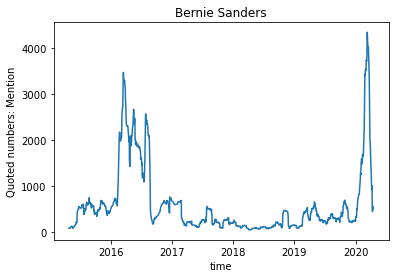

In [21]:
# For example, we can visualize the quotation changes of Bernie Sanders
candidate_quotes_mention_byday['BERNIE SANDERS'].rolling(window=30).sum().plot() # one months average
plt.xlabel('time')
plt.ylabel('Quoted numbers: Mention')
plt.title('Bernie Sanders')

In [22]:
# Add the election day corresponding to each candidate mentioned
candidate_info_byname = candidate_info.set_index(['candidate']) # Allow access info by name as index
candidate_quotes_mention['mention']=candidate_quotes_mention.mention.map(lambda x:x.upper())
candidate_quotes_mention['election_day'] = candidate_quotes_mention['mention'].map(candidate_info_byname['year']).astype(str)+ '-11-01'
candidate_quotes_mention['election_day'] = pd.to_datetime(candidate_quotes_mention['election_day'])
candidate_quotes_mention.head(4)

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,mention,domains,date_only,normalize_factor,normalize_quotes,election_day
0,2015-05-17-016225,I really like Bernie Sanders and his policies ...,None,[],2015-05-17 07:09:22,1,"[[None, 0.81], [Bernie Sanders, 0.19]]",[http://dailykos.com/story/2015/05/15/1384917/...,E,BERNIE SANDERS,[com],2015-05-17,0.880164,0.880164,2018-11-01
1,2015-08-25-018582,Elizabeth Warren does have a thumb on the puls...,Bakari Sellers,[Q4849014],2015-08-25 10:02:35,4,"[[Bakari Sellers, 0.8813], [None, 0.1075], [El...",[http://www.kspr.com/news/politics/does-elizab...,E,ELIZABETH A. WARREN,"[com, com, com, com]",2015-08-25,0.473512,1.894046,2018-11-01
2,2015-03-11-040221,I'll invoke the marital privilege on some of i...,Mike Coffman,[Q547218],2015-03-11 17:09:31,1,"[[Mike Coffman, 0.4786], [None, 0.3104], [Tom ...",[http://www.huffingtonpost.com/jason-salzman/r...,E,CORY GARDNER,[com],2015-03-11,0.535357,0.535357,2020-11-01
3,2015-09-24-081451,Richard Burr truly is North Carolina's `Invisi...,None,[],2015-09-24 02:04:45,1,"[[None, 0.7571], [Richard Burr, 0.182], [Paul ...",[http://www.wcti12.com/news/Ross-leaves-job-po...,E,RICHARD BURR,[com],2015-09-24,0.447555,0.447555,2016-11-01


Pearson coefficient: 0.5320764453359699, p value: 1.1343252830666171e-22


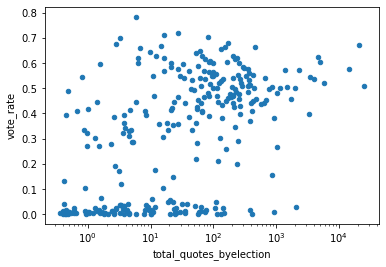

In [23]:
from scipy.stats import pearsonr

# Add election result (i.e. vote rate) for each candidate speaker
candidate_info_byname['vote_rate'] = candidate_info_byname['candidatevotes']/candidate_info_byname['totalvotes']

# We group the number of normalized quotations before election day
quotes_byelection = candidate_quotes_mention[candidate_quotes_mention['date_only'] < candidate_quotes_mention['election_day']]
tot_quotes_byelection = pd.DataFrame(quotes_byelection.groupby(['mention'])['normalize_quotes'].sum())
tot_quotes_byelection.rename(columns = {'normalize_quotes': 'total_quotes_byelection'}, inplace=True)

# We add the vote rate and plot the scatter plot of vote rate against total quotes by election
tot_quotes_byelection['vote_rate'] = tot_quotes_byelection.index.map(candidate_info_byname['vote_rate'])

# linear regression
quotes_vote = tot_quotes_byelection.plot.scatter(x = 'total_quotes_byelection', y = 'vote_rate', logx=True)
(corr1, pvalue) = pearsonr(np.log(tot_quotes_byelection['total_quotes_byelection']), tot_quotes_byelection['vote_rate'])
print(f'Pearson coefficient: {corr1}, p value: {pvalue}')

**Observation**: Based on the plot above, we can see that there is also a positive correlation between number of mentioned quotations and vote_rate with p value < 0.05.

## 2. Weigh the quotations by readership
We are aware of the different reading statistics of different media. We try to weigh the quotations by the readership of the source media.

**2.1** First, we sample 50k quotes and look at the source media of those quotations. This would give us a feel of how much media is covered by QuoteBank and which media appear most often. To balance the data said by candidates and the data mentioning candidates, we sample the 50k quotes according to the ratio of total data in 'candidate_quotes' and 'candidate_quotes_mention'

In [24]:
# sample 50k quotes and see where quotes are published
candidate_quotes_mention.reset_index(inplace=True) # Reset index of mention dataset
sample_n = 50000
said_n = len(candidate_quotes.index) # total number of quotes said by candidates
mention_n = len(candidate_quotes_mention.index) # total number of quotes mentioning candidates
mention_sample_n = int(sample_n * mention_n/(mention_n + said_n))
said_sample_n = sample_n - mention_sample_n
print('we sample {} quotes said by candidates and {} quotes mentioning candidates'.format(said_sample_n, mention_sample_n))

we sample 46123 quotes said by candidates and 3877 quotes mentioning candidates


In [25]:
# We extract the domains from two data set based on the ratio computed above
total_domains = []
said_sample = candidate_quotes.sample(said_sample_n) # sample from quotes said by candidates
# We extract web domains from the url
for i in said_sample.index:
    urls = said_sample.at[i,'urls']
    for url in urls: # Some URL here is actually a list (there are lists in list), not sure why it happens
        total_domains.append(get_tld(url, as_object=True).domain)

mention_sample = candidate_quotes.sample(mention_sample_n) # sample from quotes said by candidates
# We use the same pipeline to extract domain
for i in mention_sample.index:
    urls = mention_sample.at[i,'urls']
    for url in urls: # Some URL here is actually a list (there are lists in list), not sure why it happens
        total_domains.append(get_tld(url, as_object=True).domain)

We use the code below to find top 30 frequently appearing media in the sample. (Note: the last several media may be different from sample to sample, but overall they do not affect the result!)

In [26]:
# Count the frequency of media occurences in quotation dataset
from collections import Counter
domain_count = Counter(total_domains).most_common()
print("----top 30 news agency/publisher:\n ", domain_count[0:30])
print('----number of news agency covered:', len(domain_count))


----top 30 news agency/publisher:
  [('krmg', 5741), ('msn', 3149), ('wokv', 2790), ('news965', 2690), ('breitbart', 2489), ('washingtonexaminer', 2389), ('businessinsider', 2371), ('thehill', 2370), ('washingtontimes', 2132), ('cnn', 2124), ('yahoo', 1965), ('einnews', 1891), ('foxnews', 1739), ('cbsnews', 1727), ('newsmax', 1458), ('politico', 1434), ('nytimes', 1383), ('wsbradio', 1376), ('washingtonpost', 1325), ('sfgate', 1210), ('huffingtonpost', 1152), ('nbcnews', 1065), ('kdhnews', 1034), ('news12', 883), ('abc-7', 876), ('wftv', 855), ('rollcall', 842), ('startribune', 837), ('seattletimes', 798), ('ktvz', 793)]
----number of news agency covered: 5104


Among 50k samples, there are over 4000 different website domains, indicating a sufficiently wide coverage of media. So the quotations can be an indicator of public exposure. Besides, we observe an exponential decrease of counts in the database.

Text(0.5, 0, 'occurences in sampled quote data')

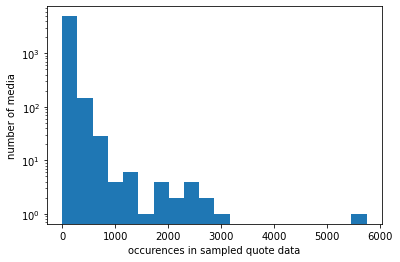

In [27]:
# Plot the histogram characterizing the frequency of each media appearing
_, y_counts = zip(*domain_count)
plt.hist(y_counts, bins=20)
plt.yscale('log')
plt.ylabel('number of media')
plt.xlabel('occurences in sampled quote data')

**Do Not Re run the cell below! In case sample changes**

10 randomly selected news agency/publisher except the top 30:

  ['bakersfield','wtkr', 'go', 'navytimes', 'advertiser-tribune', 'circleofblue', 'nbcphiladelphia', 'malaymail', 'illawarramercury', 'hawaiinewsnow']
  
The code to get the 10 random media is shown below, we comment it out because each time it selects 10 different media, which may confuse the viewer of this notebook.

In [29]:
%%script echo skipping
#media_ind = np.random.randint(31, len(domain_count), size=10)
#print("10 randomly selected news agency/publisher except the top 30:\n ", [domain_count[i] for i in media_ind])

Couldn't find program: 'echo'


The distribution is heavy-tailed, with only a few big media like CNN and Fox News occurring frequently. Most media occurs no more than 1.5% among all quotations. So, we think it is sufficient to just weigh the quotations extracted from those frequently occurring media. Moreover, it is very difficult to automatically find media's reading statistics (or other indicators of popularity) just based on the url major domain name. We could not think of a way to do so. Neither could we find an open dataset helping us. Therefore, we decide to manually look up the readership of those top 30 new agencies. For the rest media, we will sample 10 media from them and manually look up the reading statistics. We will take the average readership of those 10 media to represent the readership of the rest media. This will take up some time, so we plan to finish those manual work in the following weeks (see proposed timeline). As a result, we do not include any exposure level (quotation weighted by media readership) in Milestone 2. Instead, we just use the number of quotations (assuming all media offer the same public exposure).

**2.2** We manually search the total website visits of top 30 news agencies of the 10 randomly selected agencies among the rest. We could not find the data of some websites, so we use the median of others to fill it.

In [28]:
weight_file = 'SenateData/WebsiteVisit.csv'
weight_df = pd.read_csv(weight_file)
# Fill the NaN value by median (which avoid effect from outliers)
weight_df.loc[:, ['total_view_in_US']] = weight_df[['total_view_in_US']].fillna(weight_df[['total_view_in_US']].median())
weight_df.head(5) # demonstrate the format website view data for weight


,webdomain,media,total_view_in_US
0,KRMG,KRMG,0.11
1,news965,WBDO,21.68
2,wokv,WOKV,0.09
3,msn,MSN,323.98
4,breitbart,Breitbart,42.19


In [29]:
# Get the views for the 10 randomly selected agencies
random_file = 'SenateData/RandomVisit.csv'
random_df = pd.read_csv(random_file)
# We take the median of total_US_view of the 10 agencies, as view for other agencies
random_view = random_df['total_view_in_US'].median()
print('The median value of total views of the 10 agencies is {}'.format(random_view))

The median value of total views of the 10 agencies is 0.675


Then, we add those weights to the 'candidate_quotes' and 'candidate_quotes_mention'

In [30]:
# assign weights to quotes said by candidates
weight_dict = dict(zip(weight_df['webdomain'], weight_df['total_view_in_US']))
n_hit = 0
for i in candidate_quotes.index:
    urls = candidate_quotes.at[i,'urls']
    weight_ = 0
    for url in urls: # Some URL here is actually a list (there are lists in list), not sure why it happens
        webdomain = get_tld(url, as_object=True).domain # when it is a list, the multiply urls point to the same website
        if webdomain in weight_dict.keys():
            weight_ = weight_ + weight_dict[webdomain]
            n_hit = n_hit + 1
        else:
            weight_ = weight_ + random_view
    candidate_quotes.at[i,'views'] = weight_ 
print('For quotes said by candidates, we found {} numbers of quotation occurrences from top 30'.format(n_hit))

For quotes said by candidates, we found 1042718 numbers of quotation occurrences from top 30


In [31]:
# Multiply views by normalization factors
candidate_quotes['normalize_views'] = candidate_quotes['views']*candidate_quotes['normalize_factor']
candidate_quotes.sample(5)

,index,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,domains,normalize_factor,normalize_quotes,date_only,election_day,views,normalize_views
690311,135369,2018-10-25-044783,"I look forward to serving the state,",JIM NEWBERGER,[Q16195713],2018-10-25 17:52:10,1,"[[Jim Newberger, 0.4517], [None, 0.4296], [Amy...",[http://duluthnewstribune.com/opinion/editoria...,E,[com],0.427106,0.427106,2018-10-25,2018-11-01,0.675,0.288297
355623,41225,2017-07-28-070042,It was a victory for 15 million people who wou...,BERNIE SANDERS,[Q359442],2017-07-28 21:18:00,1,"[[Bernie Sanders, 0.6498], [None, 0.3156], [Ph...",[https://www.sevendaysvt.com/OffMessage/archiv...,E,[com],0.418827,0.418827,2017-07-28,2018-11-01,0.675,0.282708
82675,82675,2015-05-16-011571,He was right to remind everyone that `you don'...,MITCH MCCONNELL,[Q355522],2015-05-16 18:10:22,1,"[[Mitch McConnell, 0.5709], [None, 0.3574], [P...",[http://thehill.com/blogs/floor-action/senate/...,E,[com],0.880164,0.880164,2015-05-16,2020-11-01,42.070,37.028496
593511,38569,2018-11-28-056061,"It was that you had local communities, and dis...",BEN SASSE,[Q16192221],2018-11-28 18:56:02,2,"[[Ben Sasse, 0.8736], [None, 0.1264]]",[http://www.christianpost.com/news/we-in-ameri...,E,"[com, com]",0.476376,0.952751,2018-11-28,2020-11-01,1.350,0.643107
393989,79591,2017-03-03-017339,from something like Ossoffsky.,JON OSSOFF,[Q28839536],2017-03-03 00:00:00,3,"[[JON OSSOFF, 0.8146], [None, 0.1662], [Jere W...",[http://www.newyorker.com/news/news-desk/can-t...,E,"[com, com, com]",0.403952,1.211855,2017-03-03,2020-11-01,2.025,0.818002


In [32]:
# assign weights to quotes mentioning candidates
n_hit = 0
for i in candidate_quotes_mention.index:
    urls = candidate_quotes_mention.at[i,'urls']
    weight_ = 0
    for url in urls: # Some URL here is actually a list (there are lists in list), not sure why it happens
        webdomain = get_tld(url, as_object=True).domain # when it is a list, the multiply urls point to the same website
        if webdomain in weight_dict.keys():
            weight_ = weight_ + weight_dict[webdomain]
            n_hit = n_hit + 1
        else:
            weight_ = weight_ + random_view
    candidate_quotes_mention.at[i,'views'] = weight_ 
print('For quotes mentioning candidates, we found {} numbers of quotation occurrences from top 30'.format(n_hit))

For quotes mentioning candidates, we found 63187 numbers of quotation occurrences from top 30


In [33]:
# Multiply views by normalization factors
candidate_quotes_mention['normalize_views'] = candidate_quotes_mention['views']*candidate_quotes_mention['normalize_factor']
candidate_quotes_mention.sample(5)

,index,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,mention,domains,date_only,normalize_factor,normalize_quotes,election_day,views,normalize_views
67816,19812,2018-11-08-060420,It is sad and embarrassing that Bill Nelson wo...,Gov. Rick Scott,[Q439729],2018-11-08 18:31:42,2,"[[Gov. Rick Scott, 0.4812], [None, 0.4134], [M...",[http://mobile.nytimes.com/2018/11/08/us/flori...,E,BILL NELSON,"[com, com]",2018-11-08,0.476376,0.952751,2018-11-01,250.975,119.558362
92885,6900,2020-03-23-047611,President Trump and Mitch McConnell are trying...,Mitch McConnell,[Q355522],2020-03-23 15:40:00,4,"[[Mitch McConnell, 0.5638], [Joe Biden, 0.2166...",[https://www.news965.com/blog/jamie-dupree/bid...,E,MITCH MCCONNELL,"[com, com, com, com]",2020-03-23,0.755660,3.022639,2020-11-01,23.705,17.912913
54416,6412,2018-08-03-072561,Such an exciting day having lunch with @denise...,Rebecca Romijn,[Q202792],2018-08-03 14:00:04,1,"[[Rebecca Romijn, 0.7987], [None, 0.1085], [De...",[http://www.bustle.com/p/andy-cohen-wants-deni...,E,AARON DAY,[com],2018-08-03,0.497688,0.497688,2016-11-01,0.675,0.335939
8391,8391,2015-12-01-091672,"Ted Cruz's track record has a lot to attack, w...",None,[],2015-12-01 17:45:24,1,"[[None, 0.7958], [Ted Cruz, 0.1474], [Mitch Mc...",[http://www.theblaze.com/stories/2015/12/01/ey...,E,TED CRUZ,[com],2015-12-01,0.477546,0.477546,2018-11-01,0.675,0.322344
392,392,2015-09-22-132120,"When I was singing to records, I was listening...",Joanne Shaw Taylor,[Q4160356],2015-09-22 13:44:00,1,"[[Joanne Shaw Taylor, 0.4182], [None, 0.3416],...",[http://exeterexpressandecho.co.uk/British-blu...,E,DOUG COLLINS,[co.uk],2015-09-22,0.447555,0.447555,2020-11-01,0.675,0.302099


**2.3** We repeat the protocol in section **1.2-1.3** to examine the effect of weighted quotations by candidates on their election results 

In [34]:
# Clean the names by taking only upper case
# Group the candidate total number of quotes by day
candidate_quotes['speaker'] = candidate_quotes['speaker'].str.upper()
candidate_quotes['date_only'] = candidate_quotes['date'].dt.date
candidate_views_byday = candidate_quotes.groupby(['speaker', 'date_only'])['normalize_views'].sum()
candidate_views_byday

speaker           date_only 
A. WAYNE JOHNSON  2015-01-06    0.406348
                  2015-02-09    0.406745
                  2015-02-11    0.813489
                  2015-02-20    0.406745
                  2015-03-01    0.361366
                                  ...   
ZAK RINGELSTEIN   2018-10-30    3.459560
                  2018-11-01    1.607768
                  2018-11-05    0.321554
                  2018-11-07    0.321554
                  2019-03-21    0.340118
Name: normalize_views, Length: 136070, dtype: float64

Text(0.5, 1.0, 'Bernie Sanders')

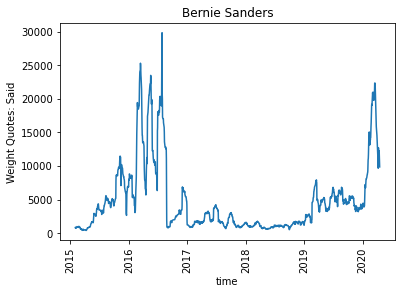

In [35]:
# For example, we can visualize the quotation changes of Bernie Sanders
candidate_quotes_byday['BERNIE SANDERS'].rolling(window=30).sum().plot() # one months average
plt.xlabel('time')
plt.xticks(rotation=90)
plt.ylabel('Weight Quotes: Said')
plt.title('Bernie Sanders')

In [36]:
# We group weighted quotations (audience views) by election day
quotes_byelection = candidate_quotes[candidate_quotes['date_only'] < candidate_quotes['election_day']]
views_byelection = pd.DataFrame(quotes_byelection.groupby(['speaker'])['normalize_views'].sum())
views_byelection.rename(columns = {'normalize_views': 'views_byelection'}, inplace=True)

Pearson coefficient: 0.6234484341423224, p value: 1.842289412561934e-27


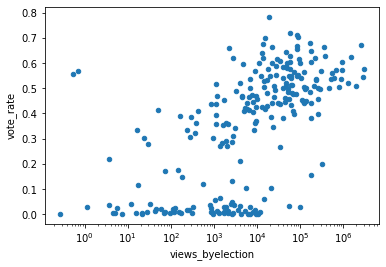

In [37]:
# We add the vote rate and plot the scatter plot of vote rate against total quotes by election
from scipy.stats import pearsonr
views_byelection['vote_rate'] = views_byelection.index.map(candidate_info_byname['vote_rate'])
views_vote = views_byelection.plot.scatter(x = 'views_byelection', y = 'vote_rate', logx=True)
(corr1, pvalue) = pearsonr(np.log(views_byelection['views_byelection']), views_byelection['vote_rate'])
print(f'Pearson coefficient: {corr1}, p value: {pvalue}')


We notice very little change in the Pearson coefficient and p-value when comparing the result to section **1.3** (where we did not weigh the quotes by website views). 

**2.4** We repeat the protocol in section **1.4** to examine the effect of weighted quotations mentioning candidates on their election results

In [38]:
# obtain normalized views by day
candidate_quotes_mention_byday = candidate_quotes_mention.groupby(['mention', 'date_only'])['normalize_views'].sum()
candidate_quotes_mention_byday

mention           date_only 
A. WAYNE JOHNSON  2015-01-16      0.406348
                  2015-08-04    153.408265
                  2015-12-11      0.644688
                  2017-02-12      1.404049
                  2017-05-28      0.270903
                                   ...    
WILLIE L. WILSON  2019-03-30      0.340118
                  2019-07-16     28.203418
                  2019-11-04     11.759805
ZAK RINGELSTEIN   2018-06-22      0.325350
                  2018-10-24      0.288297
Name: normalize_views, Length: 34904, dtype: float64

Text(0.5, 1.0, 'Bernie Sanders')

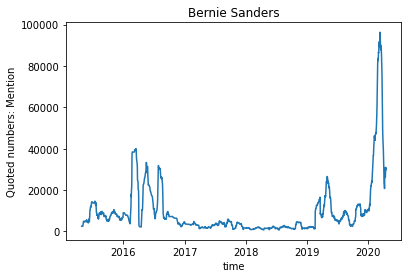

In [39]:
# For example, we can visualize the normalized view changes of Bernie Sanders
candidate_quotes_mention_byday['BERNIE SANDERS'].rolling(window=30).sum().plot() # one months average
plt.xlabel('time')
plt.ylabel('Quoted numbers: Mention')
plt.title('Bernie Sanders')

Pearson coefficient: 0.5944534670274673, p value: 3.416648866161509e-29


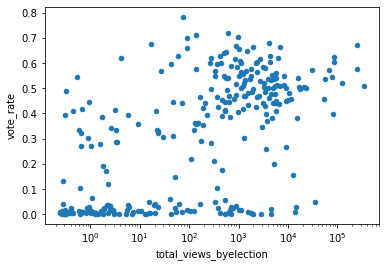

In [40]:
from scipy.stats import pearsonr

# We group the number of normalized views before election day
quotes_byelection = candidate_quotes_mention[candidate_quotes_mention['date_only'] < candidate_quotes_mention['election_day']]
tot_quotes_byelection = pd.DataFrame(quotes_byelection.groupby(['mention'])['normalize_views'].sum())
tot_quotes_byelection.rename(columns = {'normalize_views': 'total_views_byelection'}, inplace=True)

# We add the vote rate and plot the scatter plot of vote rate against total quotes by election
tot_quotes_byelection['vote_rate'] = tot_quotes_byelection.index.map(candidate_info_byname['vote_rate'])

# linear regression
quotes_vote = tot_quotes_byelection.plot.scatter(x = 'total_views_byelection', y = 'vote_rate', logx=True)
(corr1, pvalue) = pearsonr(np.log(tot_quotes_byelection['total_views_byelection']), tot_quotes_byelection['vote_rate'])
print(f'Pearson coefficient: {corr1}, p value: {pvalue}')

Again, we notice very little change in the Pearson coefficient and p-value when comparing the result to section **1.4** (where we did not weigh the quotes by website views). 

# 3. Clustering the quotation data
To answer our proposed question 3, we clustered the quotation data to find different exposure-gaining process.

We will extract feature for each senate candidate.

In [41]:
candidate_quotes['days_before_election'] = pd.to_datetime(candidate_quotes['election_day'])- pd.to_datetime(candidate_quotes['date_only'])
candidate_quotes['days_before_election'] = candidate_quotes['days_before_election'].map(lambda x:x.days)
candidate_quotes.sample(4)

,index,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,domains,normalize_factor,normalize_quotes,date_only,election_day,views,normalize_views,days_before_election
1073628,36398,2020-01-11-043513,They can look at something that is unequivocal...,TOM COTTON,[Q3090307],2020-01-11 22:22:52,1,"[[Tom Cotton, 0.8149], [None, 0.1371], [Presid...",[http://www.breitbart.com/politics/2020/01/11/...,E,[com],0.577288,0.577288,2020-01-11,2020-11-01,42.19,24.355776,295
881381,72928,2019-02-08-088742,The interest here is that there be free and fa...,MARCO RUBIO,[Q324546],2019-02-08 04:04:35,2,"[[Marco Rubio, 0.8098], [None, 0.1861], [Nicol...",[http://wftv.com/news/local/rubio-all-options-...,E,"[com, com]",0.541812,1.083623,2019-02-08,2016-11-01,3.10,1.679616,-829
813377,4924,2019-09-16-064961,READ stunning NYT CORRECTION. If a high-school...,TED CRUZ,[Q2036942],2019-09-16 19:52:24,1,"[[Ted Cruz, 0.8623], [None, 0.1217], [Brett Ka...",[http://www.breitbart.com/politics/2019/09/16/...,E,[com],0.543010,0.543010,2019-09-16,2018-11-01,42.19,22.909576,-319
969983,161530,2019-05-26-001965,All of the stakeholders came together to reall...,KARIN HOUSLEY,[Q16195595],2019-05-26 11:52:10,2,"[[Karin Housley, 0.8808], [None, 0.1193]]",[https://minnesota.cbslocal.com/2019/05/26/mn-...,E,"[com, com]",0.488273,0.976546,2019-05-26,2018-11-01,1.35,0.659169,-206


In [42]:
feature_length = 300  # we use data of 100 days before the election
quotes_timespan = candidate_quotes[candidate_quotes['days_before_election']>=0]
quotes_timespan = quotes_timespan[quotes_timespan['days_before_election']<feature_length]
quotes_timespan.sample(4)

,index,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,domains,normalize_factor,normalize_quotes,date_only,election_day,views,normalize_views,days_before_election
258916,67332,2016-02-22-010440,Because this campaign now has repeatedly done ...,MARCO RUBIO,[Q324546],2016-02-22 21:20:01,1,"[[Marco Rubio, 0.6456], [None, 0.2739], [Rafae...",[http://cbsnews.com/news/marco-rubio-calls-for...,E,[com],0.959534,0.959534,2016-02-22,2016-11-01,24.880,23.873196,253
727203,172261,2018-02-22-113108,That is a message that resonates with young pe...,TED CRUZ,[Q2036942],2018-02-22 21:14:04,1,"[[Ted Cruz, 0.8032], [None, 0.1968]]",[https://www.westernjournal.com/cruz-exposes-w...,E,[com],0.401482,0.401482,2018-02-22,2018-11-01,0.675,0.271000,252
275576,83992,2016-02-23-134775,This is about a lame-duck president who will b...,JOHN MCCAIN,[Q10390],2016-02-23 08:47:34,1,"[[John McCain, 0.8838], [None, 0.1053], [Clare...",[http://azcentral.com/story/opinion/op-ed/ej-m...,E,[com],0.959534,0.959534,2016-02-23,2016-11-01,0.675,0.647685,252
610080,55138,2018-01-15-047231,it must support national and international pol...,BERNIE SANDERS,[Q359442],2018-01-15 18:30:15,1,"[[Bernie Sanders, 0.8879], [None, 0.1121]]",[http://alternet.org/news-amp-politics/bernie-...,E,[org],0.402250,0.402250,2018-01-15,2018-11-01,0.675,0.271519,290


In [43]:
# group the quotations by speaker
quotes_timespan_byday = quotes_timespan.groupby(['speaker', 'days_before_election'])['normalize_views'].sum()
quotes_timespan_byday

speaker           days_before_election
A. WAYNE JOHNSON  225                      0.510070
                  234                      2.040281
                  241                     11.395348
                  251                     99.717389
                  261                      2.532803
                                            ...    
ZAK RINGELSTEIN   141                      1.626749
                  147                      0.650700
                  160                      0.815621
                  227                      1.933979
                  235                      0.241747
Name: normalize_views, Length: 19165, dtype: float64

In [44]:
# build the feature vectors

candidate_name = quotes_timespan_byday.index.map(lambda x:x[0]).drop_duplicates()
candidate_quotes_cluster_feature = pd.DataFrame(np.zeros([feature_length,len(candidate_name)]), columns=candidate_name)

for candidate in candidate_name:
    candidate_quotes_timespan = quotes_timespan_byday[candidate]
    for days in candidate_quotes_timespan.index:
        candidate_quotes_cluster_feature[candidate].iloc[days] = candidate_quotes_timespan.loc[days]
        
candidate_quotes_cluster_feature

,A. WAYNE JOHNSON,AARON JAMES,ABHAY PATEL,AL GROSS,ALEX MERCED,ALLEN BUCKLEY,AMY KLOBUCHAR,AMY MCGRATH,ANN KIRKPATRICK,ARN MENCONI,...,TOM COTTON,TOM JONES,TOMMY TUBERVILLE,TONY CAMPBELL,TROY HEBERT,VALENCIA STOVALL,WENDY LONG,"WILLIAM ROBERT LANG, JR.",WILLIE L. WILSON,ZAK RINGELSTEIN
0,0.0,0.000000,0.0,0.0,0.0,0.0,0.643107,0.000000,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,1.607768
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.864890,0.000000,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
2,0.0,0.000000,0.0,0.0,0.0,0.0,41.414354,0.000000,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,3.459560
3,0.0,0.000000,0.0,0.0,0.0,0.0,4.324450,0.000000,0.0,0.0,...,0.000000,0.0,0.000000,2.306374,0.0,0.0,0.0,0.0,0.0,0.576593
4,0.0,0.000000,0.0,0.0,0.0,0.0,4.901044,0.000000,0.0,0.0,...,0.000000,0.0,0.000000,2.882967,0.0,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,0.0,0.000000,0.0,0.0,0.0,0.0,69.388074,0.000000,0.0,0.0,...,552.756030,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
296,0.0,1.169008,0.0,0.0,0.0,0.0,8.435176,0.000000,0.0,0.0,...,3.896693,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
297,0.0,0.779339,0.0,0.0,0.0,0.0,1.357593,1.169008,0.0,0.0,...,239.637971,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
298,0.0,0.779339,0.0,0.0,0.0,0.0,0.814556,0.000000,0.0,0.0,...,726.124239,0.0,191.316089,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000


Since the feature vector is 300-dimension, we will use PCA to reduce the dimension and visualize the data.

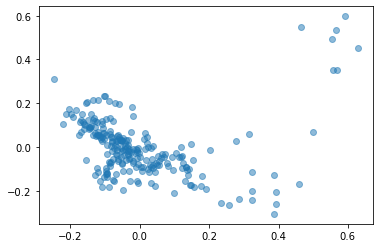

In [45]:
# Use PCA to visualize the feature vectors
from sklearn.decomposition import PCA

candidate_feature_vectors = candidate_quotes_cluster_feature.to_numpy().T
candidate_feature_vectors/=np.linalg.norm(candidate_feature_vectors,axis=1)[:,np.newaxis]
reduced_feature_PCA = PCA(n_components=2).fit(candidate_feature_vectors).transform(candidate_feature_vectors)

plt.scatter(reduced_feature_PCA[:,0],reduced_feature_PCA[:,1], alpha=0.5)

In the reduced space, we applied KMeans for clustering.

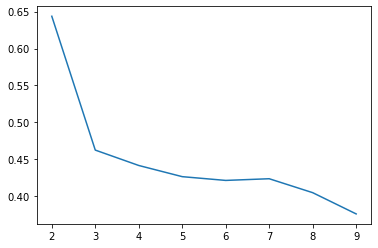

In [46]:
# find the cluster number to use

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

silhouettes=[]
for n_clusters in range(2,10):
    labels = KMeans(n_clusters=n_clusters).fit_predict(reduced_feature_PCA)
    score = silhouette_score(reduced_feature_PCA,labels)
    silhouettes.append(score)
    
plt.plot(range(2,10),silhouettes)

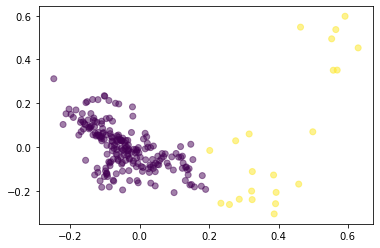

In [47]:
# based on previous result, we use 3 clusters.
n_clusters = 2
labels = KMeans(n_clusters=n_clusters).fit_predict(reduced_feature_PCA)
plt.scatter(reduced_feature_PCA[:,0],reduced_feature_PCA[:,1], alpha=0.5,c=labels)

In [48]:
# show candidates of each cluster

for candidate_type in range(0,n_clusters):
    print('{} candidates in type {}: {}'.format(np.where(labels==candidate_type)[0].shape[0],candidate_type,candidate_name[np.where(labels==candidate_type)]))

212 candidates in type 0: Index(['A. WAYNE JOHNSON', 'AARON JAMES', 'ABHAY PATEL', 'AL GROSS',
       'ALEX MERCED', 'ALLEN BUCKLEY', 'AMY KLOBUCHAR', 'ANN KIRKPATRICK',
       'ARN MENCONI', 'ARVIN VOHRA',
       ...
       'TOM CONNORS', 'TOM JONES', 'TOMMY TUBERVILLE', 'TONY CAMPBELL',
       'TROY HEBERT', 'VALENCIA STOVALL', 'WENDY LONG',
       'WILLIAM ROBERT LANG, JR.', 'WILLIE L. WILSON', 'ZAK RINGELSTEIN'],
      dtype='object', length=212)
22 candidates in type 1: Index(['AMY MCGRATH', 'BEN SASSE', 'CORY BOOKER', 'CORY GARDNER',
       'DAVID A. PERDUE', 'DOUG COLLINS', 'DOUG JONES', 'GARY PETERS',
       'JEANNE SHAHEEN', 'JEFF MERKLEY', 'JOHN CORNYN', 'JON OSSOFF',
       'JONI ERNST', 'LINDSEY GRAHAM', 'MARK KELLY', 'MARK R. WARNER',
       'MITCH MCCONNELL', 'SARA I. GIDEON', 'SHELLEY MOORE CAPITO',
       'SUSAN MARGARET COLLINS', 'THOM TILLIS', 'TOM COTTON'],
      dtype='object')


After clustering, we'd like to know how each cluster looks like. Firstly we just average the feature from each cluster and visualize them.

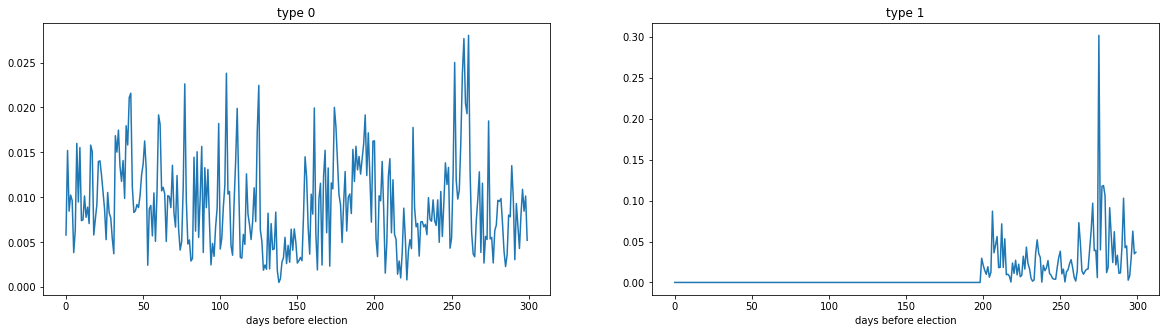

In [49]:
fig, axs = plt.subplots(1,n_clusters, figsize=(20,5))
for candidate_type in range(0,n_clusters):
    axs[candidate_type].plot(range(0,feature_length), np.mean(candidate_feature_vectors[np.where(labels==candidate_type)], axis=0))
    axs[candidate_type].set_title('type {}'.format(candidate_type))
    axs[candidate_type].set_xlabel('days before election')

We try to remove candidate of 2020 because the lack of data after April. This is shown in type 1, where we get almost no citation from roughly 200 days before election. This is mainly caused by lacking quotation data after April 2020 in the QuoteBank.

In [50]:
# find each candidates' election year.

election_year = candidate_info_byname.loc[candidate_name]['year']
election_year

A. WAYNE JOHNSON            2020
AARON JAMES                 2020
ABHAY PATEL                 2016
AL GROSS                    2020
ALEX MERCED                 2016
                            ... 
VALENCIA STOVALL            2020
WENDY LONG                  2016
WILLIAM ROBERT LANG, JR.    2016
WILLIE L. WILSON            2020
ZAK RINGELSTEIN             2018
Name: year, Length: 234, dtype: int64

In [51]:
# filt out 2020 election

candidate_name_filted = candidate_name[election_year!=2020]
candidate_name_filted

Index(['ABHAY PATEL', 'ALEX MERCED', 'ALLEN BUCKLEY', 'AMY KLOBUCHAR',
       'ANN KIRKPATRICK', 'ARN MENCONI', 'ARVIN VOHRA', 'BARRY MICHAELS',
       'BEN CARDIN', 'BERNIE SANDERS',
       ...
       'TIMOTHY M. KAINE', 'TINA SMITH', 'TODD C. YOUNG', 'TOM CONNORS',
       'TOM JONES', 'TONY CAMPBELL', 'TROY HEBERT', 'WENDY LONG',
       'WILLIAM ROBERT LANG, JR.', 'ZAK RINGELSTEIN'],
      dtype='object', length=171)

In [52]:
# rebuild our feature vectors

candidate_quotes_cluster_feature_filted = pd.DataFrame(np.zeros([feature_length,len(candidate_name_filted)]), columns=candidate_name_filted)

for candidate in candidate_name_filted:
    candidate_quotes_timespan = quotes_timespan_byday[candidate]
    for days in candidate_quotes_timespan.index:
        candidate_quotes_cluster_feature_filted[candidate].iloc[days] = candidate_quotes_timespan.loc[days]
        
candidate_quotes_cluster_feature_filted

,ABHAY PATEL,ALEX MERCED,ALLEN BUCKLEY,AMY KLOBUCHAR,ANN KIRKPATRICK,ARN MENCONI,ARVIN VOHRA,BARRY MICHAELS,BEN CARDIN,BERNIE SANDERS,...,TIMOTHY M. KAINE,TINA SMITH,TODD C. YOUNG,TOM CONNORS,TOM JONES,TONY CAMPBELL,TROY HEBERT,WENDY LONG,"WILLIAM ROBERT LANG, JR.",ZAK RINGELSTEIN
0,0.0,0.0,0.0,0.643107,0.0,0.0,0.000000,0.00000,0.964661,60.447298,...,0.0,45.258062,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,1.607768
1,0.0,0.0,0.0,0.864890,0.0,0.0,0.000000,0.00000,0.864890,1160.084533,...,0.0,0.576593,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
2,0.0,0.0,0.0,41.414354,0.0,0.0,0.000000,0.00000,3.171264,89.959246,...,0.0,45.040485,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,3.459560
3,0.0,0.0,0.0,4.324450,0.0,0.0,1.153187,0.00000,3.171264,407.068522,...,0.0,0.000000,0.0,0.0,0.0,2.306374,0.0,0.0,0.0,0.576593
4,0.0,0.0,0.0,4.901044,0.0,0.0,0.000000,0.86489,3.747857,2512.988300,...,0.0,1.441483,0.0,0.0,0.0,2.882967,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,0.0,0.0,0.0,69.388074,0.0,0.0,0.000000,0.00000,3532.054072,0.814556,...,0.0,1.900630,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
296,0.0,0.0,0.0,8.435176,0.0,0.0,0.000000,0.00000,1112.789610,203.735452,...,0.0,0.814556,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
297,0.0,0.0,0.0,1.357593,0.0,0.0,0.000000,0.00000,0.271519,51.317006,...,0.0,47.781231,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
298,0.0,0.0,0.0,0.814556,0.0,0.0,0.000000,0.00000,0.814556,943.311754,...,0.0,11.150362,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000


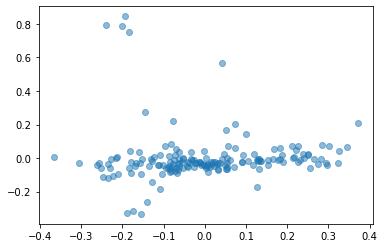

In [53]:
# PCA visualization
candidate_feature_vectors = candidate_quotes_cluster_feature_filted.to_numpy().T
candidate_feature_vectors/=np.linalg.norm(candidate_feature_vectors,axis=1)[:,np.newaxis]
reduced_feature_PCA = PCA(n_components=2).fit(candidate_feature_vectors).transform(candidate_feature_vectors)

plt.scatter(reduced_feature_PCA[:,0],reduced_feature_PCA[:,1], alpha=0.5)

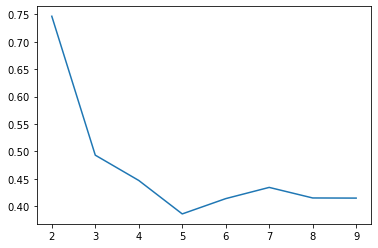

In [54]:
# find cluster number
silhouettes=[]
for n_clusters in range(2,10):
    labels = KMeans(n_clusters=n_clusters).fit_predict(reduced_feature_PCA)
    score = silhouette_score(reduced_feature_PCA,labels)
    silhouettes.append(score)
    
plt.plot(range(2,10),silhouettes)

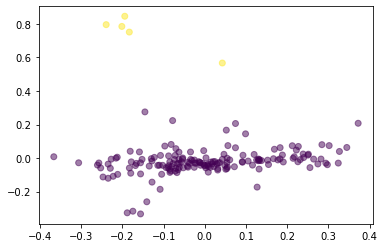

In [55]:
n_clusters = 2
labels = KMeans(n_clusters=n_clusters).fit_predict(reduced_feature_PCA)
plt.scatter(reduced_feature_PCA[:,0],reduced_feature_PCA[:,1], alpha=0.5,c=labels)

In [56]:
# again we show the candidates of each cluster
for candidate_type in range(0,n_clusters):
    print('{} candidates in type {}: {}'.format(np.where(labels==candidate_type)[0].shape[0],candidate_type,candidate_name[np.where(labels==candidate_type)]))

166 candidates in type 0: Index(['A. WAYNE JOHNSON', 'AARON JAMES', 'ABHAY PATEL', 'AL GROSS',
       'ALEX MERCED', 'ALLEN BUCKLEY', 'AMY KLOBUCHAR', 'AMY MCGRATH',
       'ANN KIRKPATRICK', 'ARN MENCONI',
       ...
       'MITCH MCCONNELL', 'MITT ROMNEY', 'MOHAMMAD "MIKE OBAMA" ARIF',
       'MURRAY SABRIN', 'NEAL SIMON', 'PATRICK "PAT" THOMAS',
       'PATRICK J. LEAHY', 'PATRICK J. TOOMEY', 'PATRICK MORRISEY',
       'PATRICK MURPHY'],
      dtype='object', length=166)
5 candidates in type 1: Index(['BOB WALSH', 'JEFF RUSSELL', 'JERRY STURGILL', 'JOHNNY ISAKSON',
       'MARK KIRK'],
      dtype='object')


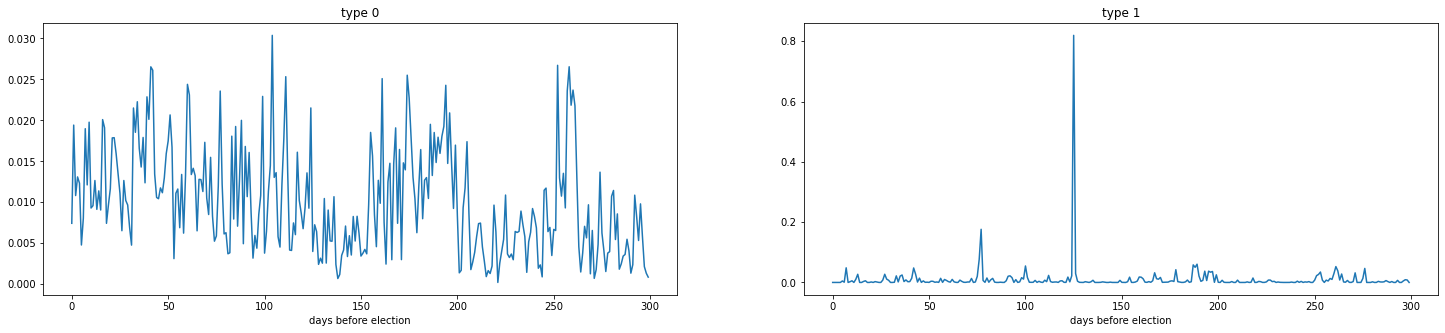

In [57]:
# use simple average to visualize the pattern of each cluster
fig, axs = plt.subplots(1,n_clusters, figsize=(25,5))
for candidate_type in range(0,n_clusters):
    axs[candidate_type].plot(range(0,feature_length), np.mean(candidate_feature_vectors[np.where(labels==candidate_type)], axis=0))
    axs[candidate_type].set_title('type {}'.format(candidate_type))
    axs[candidate_type].set_xlabel('days before election')

We also noticed that for most candidates, their quotation number of each day is relatively sparse. So it is resonable to use a longer time interval for our feature vectors. Here we sum the quotation number of each 30 days.

In [58]:
# sum for each 30 day
candidate_feature_vectors = candidate_quotes_cluster_feature_filted.to_numpy().T
candidate_feature_vectors/=np.linalg.norm(candidate_feature_vectors,axis=1)[:,np.newaxis]
candidate_feature_vectors_sum = np.array(np.split(candidate_feature_vectors,10, axis=1)).sum(axis=2).T

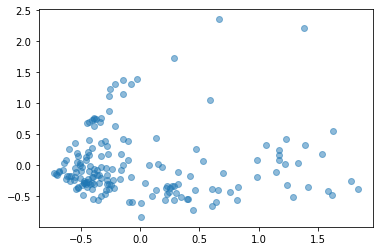

In [59]:
# PCA visualization
reduced_feature_PCA = PCA(n_components=2).fit(candidate_feature_vectors_sum).transform(candidate_feature_vectors_sum)

plt.scatter(reduced_feature_PCA[:,0],reduced_feature_PCA[:,1], alpha=0.5)

Text(0.5, 0, 'n_clusters')

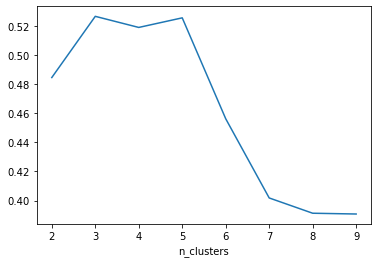

In [60]:
silhouettes=[]
for n_clusters in range(2,10):
    labels = KMeans(n_clusters=n_clusters).fit_predict(reduced_feature_PCA)
    score = silhouette_score(reduced_feature_PCA,labels)
    silhouettes.append(score)
    
plt.plot(range(2,10),silhouettes)
plt.xlabel('n_clusters')

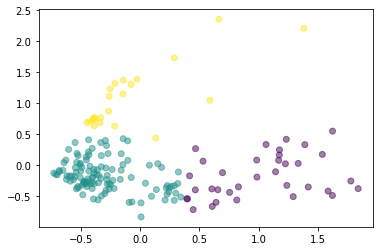

In [61]:
n_clusters = 3
labels = KMeans(n_clusters=n_clusters).fit_predict(reduced_feature_PCA)
plt.scatter(reduced_feature_PCA[:,0],reduced_feature_PCA[:,1], alpha=0.5,c=labels)

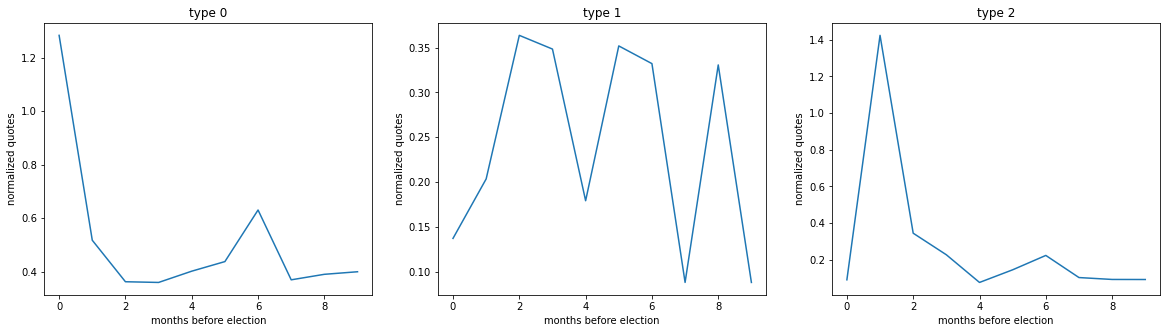

In [63]:
fig, axs = plt.subplots(1,n_clusters, figsize=(20,5))
for candidate_type in range(0,n_clusters):
    axs[candidate_type].plot(range(0,10), np.mean(candidate_feature_vectors_sum[np.where(labels==candidate_type)], axis=0))
    axs[candidate_type].set_title('type {}'.format(candidate_type))
    axs[candidate_type].set_xlabel('months before election')
    axs[candidate_type].set_ylabel('normalized quotes')

In [64]:
for candidate_type in range(0,n_clusters):
    print('{} candidates in type {}: {}'.format(np.where(labels==candidate_type)[0].shape[0],candidate_type,candidate_name_filted[np.where(labels==candidate_type)]))

35 candidates in type 0: Index(['BERNIE SANDERS', 'BETO O'ROURKE', 'BILL NELSON', 'BOB HUGIN',
       'CHELE CHIAVACCI FARLEY', 'CLAIRE MCCASKILL', 'DEAN HELLER',
       'ELIZABETH A. WARREN', 'ERIC L. BRAKEY', 'HEIDI HEITKAMP',
       'JACKY ROSEN', 'JIM NEWBERGER', 'JOE DONNELLY', 'JOE MANCHIN',
       'JOHN BARRASSO', 'JOHN JAMES', 'JON TESTER', 'JOSH HAWLEY',
       'KARIN HOUSLEY', 'KEVIN CRAMER', 'KIRSTEN E. GILLIBRAND',
       'KYRSTEN SINEMA', 'LEAH VUKMIR', 'MARSHA BLACKBURN', 'MARTHA MCSALLY',
       'MITT ROMNEY', 'MURRAY SABRIN', 'PATRICK MORRISEY', 'PHIL BREDESEN',
       'RICK SCOTT', 'ROBERT MENENDEZ', 'SHERROD BROWN', 'TAMMY BALDWIN',
       'TED CRUZ', 'TINA SMITH'],
      dtype='object')
113 candidates in type 1: Index(['ABHAY PATEL', 'ALEX MERCED', 'ALLEN BUCKLEY', 'ANN KIRKPATRICK',
       'ARN MENCONI', 'ARVIN VOHRA', 'BARRY MICHAELS', 'BEN CARDIN',
       'BRAD J. PEACOCK', 'BRIAN SCHATZ',
       ...
       'THOMAS R CARPER', 'TIM HAGAN', 'TIM SCOTT', 'TIMOTHY M. 

Text(0.5, 1.0, 'Leah Vukmir, Type 0 Example')

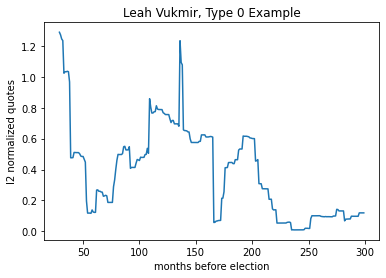

In [70]:
# From type 0
candidate_quotes_cluster_feature_filted['LEAH VUKMIR'].rolling(window=30).sum().plot()
plt.xlabel('months before election')
plt.ylabel('l2 normalized quotes')
plt.title('Leah Vukmir, Type 0 Example')

Text(0.5, 1.0, 'Tim Scott, Type 1 Example')

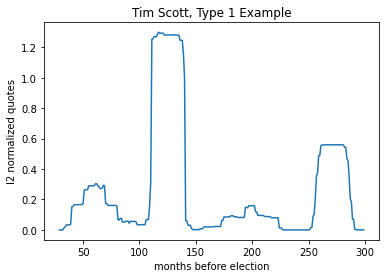

In [71]:
# From type 1
candidate_quotes_cluster_feature_filted['TIM SCOTT'].rolling(window=30).sum().plot()
plt.xlabel('months before election')
plt.ylabel('l2 normalized quotes')
plt.title('Tim Scott, Type 1 Example')

Text(0.5, 1.0, 'Jerry Sturgill, Type 2 Example')

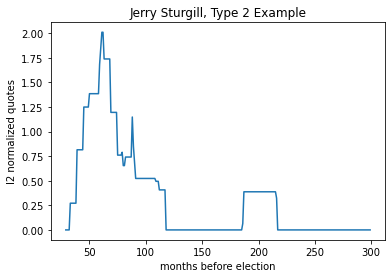

In [72]:
# From type 2
candidate_quotes_cluster_feature_filted['JERRY STURGILL'].rolling(window=30).sum().plot()
plt.xlabel('months before election')
plt.ylabel('l2 normalized quotes')
plt.title('Jerry Sturgill, Type 2 Example')

In [74]:
voterate_type0 = candidate_info_byname.loc[candidate_name_filted[np.where(labels==0)]]['vote_rate']
voterate_type1 = candidate_info_byname.loc[candidate_name_filted[np.where(labels==1)]]['vote_rate']
voterate_type2 = candidate_info_byname.loc[candidate_name_filted[np.where(labels==2)]]['vote_rate']

([<matplotlib.axis.XTick at 0x190ad1cd250>,
 [Text(1, 0, 'type0'), Text(2, 0, 'type1'), Text(3, 0, 'type2')])

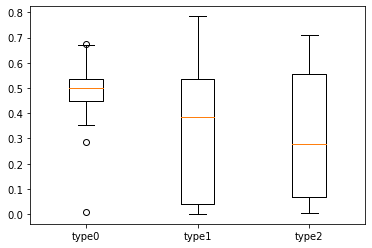

In [75]:
plt.boxplot([voterate_type0.to_numpy(),voterate_type1.to_numpy(),voterate_type2.to_numpy()])
plt.xticks([1, 2, 3], ['type0', 'type1', 'type2'])

In [77]:
from scipy.stats import ttest_ind
print(ttest_ind(voterate_type0.to_numpy(),voterate_type1.to_numpy()))
print(ttest_ind(voterate_type0.to_numpy(),voterate_type2.to_numpy()))
print(ttest_ind(voterate_type1.to_numpy(),voterate_type2.to_numpy()))

Ttest_indResult(statistic=3.5554217588675883, pvalue=0.0005090308639396297)
Ttest_indResult(statistic=3.4156442755250054, pvalue=0.0011906388893072695)
Ttest_indResult(statistic=0.3958945279886066, pvalue=0.6928124741628414)


The voterate of type 0 is significantly higher than other types.

# 4. Prediction Model
In this section, we will try to build the prediction model that uses the senate quotation data to predict election result.

**4.1:** First, we label the data by whether the candidate win the election in a new column 'is_winner'

In [69]:
# Add 'is_winner' feature
candidate_info['is_winner'] = False
candidate_info.loc[candidate_info.groupby(['year', 'state'])['candidatevotes'].idxmax(), 'is_winner'] = True
candidate_info[candidate_info['is_winner'] == True].head(5) # we display 5 winners

,year,state,state_po,state_fips,state_cen,state_ic,office,district,stage,special,candidate,party_detailed,writein,mode,candidatevotes,totalvotes,unofficial,version,party_simplified,is_winner
1,2016,ALABAMA,AL,1,63,41,US SENATE,statewide,gen,False,RICHARD C. SHELBY,REPUBLICAN,False,total,1335104,2087444,False,20210114,REPUBLICAN,True
7,2016,ALASKA,AK,2,94,81,US SENATE,statewide,gen,False,LISA MURKOWSKI,REPUBLICAN,False,total,138149,311441,False,20210114,REPUBLICAN,True
12,2016,ARIZONA,AZ,4,86,61,US SENATE,statewide,gen,False,JOHN MCCAIN,REPUBLICAN,False,total,1359267,2530730,False,20210114,REPUBLICAN,True
14,2016,ARKANSAS,AR,5,71,42,US SENATE,statewide,gen,False,JOHN BOOZMAN,REPUBLICAN,False,total,661984,1107522,False,20210114,REPUBLICAN,True
18,2016,CALIFORNIA,CA,6,93,71,US SENATE,statewide,gen,False,KAMALA D. HARRIS,DEMOCRAT,False,total,7542753,12244170,False,20210114,DEMOCRAT,True


We notice that the dataset also contains situation in which more than one senate are elected in a state in the same year (such situations are officialy called special senate election in the U.S.). To find these special elections, we check whether the sum of candidate votes exceed the total number of votes. 

In [70]:
# Find the special situations
sanity = candidate_info.groupby(['year', 'state'])['candidatevotes'].sum() <= candidate_info.groupby(['year', 'state'])['totalvotes'].mean()
sanity[sanity == False]

year  state      
2018  MINNESOTA      False
      MISSISSIPPI    False
2020  GEORGIA        False
dtype: bool

After manually looking at the dataset, we find two more winners: Tina Smith in 2018 Minnesota election and Cindy Hyde-Smith in 2018 MIssissippi election. The 2020 Georgia election held an additional runoff in 2021, in which Jon Ossof actually won the election. However, since QuoteBank only contains citations before April 2020, the data cannot reflect quotation changes before elections. We have decided not to include elections happening since 2020. So, we just add the two previously overlooked winners.

In [71]:
# Add winners in special elections
candidate_info.loc[candidate_info['candidate'] == 'TINA SMITH','is_winner'] = True
candidate_info.loc[candidate_info['candidate'] == 'CINDY HYDE-SMITH','is_winner'] = True

**4.2:** we now generate features by concatenating the monthly discretized quotation data (defined in clustering section above) and affiliated party information (defined below)

Since affiliated party plays an important role in election, we  include the party affiliation of each candidate. For senate elction in each state, we also consider the affiliated party's vote rate in the most recent presidential election. Since we are looking at the senate election from 2016 to 2029, we will use the 2016 presidential election data.

The presidential election data also comes from the MIT Election Data and Science Lab[2]. It contains the presidential election voting result by each state.

[2]MIT Election Data and Science Lab, 2017, "U.S. President 1976–2020", https://doi.org/10.7910/DVN/42MVDX, Harvard Dataverse, V6.

In [72]:
# We load 2016 result separately
president = pd.read_csv('SenateData/1976-2020-president.csv')
president16 = president[president['year'] == 2016].copy()
president16.sample(4) #display format of president election data

,year,state,state_po,state_fips,state_cen,state_ic,office,candidate,party_detailed,writein,candidatevotes,totalvotes,version,notes,party_simplified
3538,2016,MARYLAND,MD,24,52,52,US PRESIDENT,"STEIN, JILL",GREEN,False,35945,2781446,20210113,NaN,OTHER
3721,2016,WEST VIRGINIA,WV,54,55,56,US PRESIDENT,"STEIN, JILL",GREEN,False,8075,713051,20210113,NaN,OTHER
3434,2016,COLORADO,CO,8,84,62,US PRESIDENT,"STEIN, JILL",GREEN,False,38437,2780220,20210113,NaN,OTHER
3725,2016,WISCONSIN,WI,55,35,25,US PRESIDENT,"JOHNSON, GARY",LIBERTARIAN,False,106674,2976150,20210113,NaN,LIBERTARIAN


In [73]:
# We add vote rate to each candidate in each state
president16['vote_rate'] = president16['candidatevotes']/president16['totalvotes']
# We group the data by states and party_simplified (represent small parties, independent, NaN all by 'Others'). 
# We take sum of vote rates of cadidates from the same party_simplified
vote_byparty16 = president16.groupby(['state', 'party_simplified'])['vote_rate'].sum()
vote_byparty16

state      party_simplified
ALABAMA    DEMOCRAT            0.343579
           LIBERTARIAN         0.020942
           OTHER               0.014648
           REPUBLICAN          0.620831
ALASKA     DEMOCRAT            0.365509
                                 ...   
WISCONSIN  REPUBLICAN          0.472182
WYOMING    DEMOCRAT            0.216289
           LIBERTARIAN         0.051343
           OTHER               0.058384
           REPUBLICAN          0.673984
Name: vote_rate, Length: 201, dtype: float64

In [74]:
# We create feature dataframe and add in party_simplified, party vote rate in most recent presidential election, and final vote rate
# If the senate candidate's affiliated party does not show up in the most recent president election, party_vote_rate is 0
party_features = candidate_info_byname[['party_simplified']].copy()
for name in party_features.index:
    state_ = candidate_info_byname.loc[name, 'state']
    party_ = candidate_info_byname.loc[name, 'party_simplified']
    if party_ in vote_byparty16[state_].index:  #check whether the affiliated party is in recent president election
        party_features.loc[name, 'party_vote_rate'] = vote_byparty16[state_][party_]
    else: 
        party_features.loc[name, 'party_vote_rate'] = 0
        
party_features.sample(5)

,party_simplified,party_vote_rate
candidate,,
MARGARET STOCK,OTHER,0.062905
BRECK A. CRAIG,OTHER,0.062905
NICHOLAS N. GLENN,OTHER,0.020686
MIKE WORKMAN,DEMOCRAT,0.289317
CHARLES E. SCHUMER,OTHER,0.107370


In [75]:
# We get the candidates used for model and extract the vector corresponding to affliated party's performance in last election
candidates_model = candidate_quotes_cluster_feature_filted.T.index
party_vote_model = party_features.loc[candidates_model].party_vote_rate
# We then concatenate this vector to our model
features = np.concatenate((candidate_feature_vectors_sum, party_vote_model.to_numpy()[:, np.newaxis]), axis=1)
print('we have feature vectors from {} candidates, each with dimension {}'.format(features.shape[0], features.shape[1]))

we have feature vectors from 132 candidates, each with dimension 11


In [76]:
# we also obtain the corresponding labels, with 0 meaning lose and 1 meaning win
labels = candidate_info.set_index('candidate').loc[candidates_model].is_winner.astype(int).to_numpy()
print('we have {} winner candidates and {} loser candidate'.format(sum(labels), len(labels) - sum(labels)))


we have 51 winner candidates and 81 loser candidate


In [77]:
# This helps split the data if we want to split train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.25, random_state=123)
print('we have {} training data and {} test data'.format(len(y_train), len(y_test)))

we have 99 training data and 33 test data


**4.3:** We build a Logistic Regression Model to predict the result

In [78]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.metrics import accuracy_score, f1_score

We use 5-fold cross-validation on the whole dataset, to see how well logistic regression can perform on training set.

In [79]:
logistic = LogisticRegression(solver='lbfgs')
precision = cross_val_score(logistic, X_train, y_train, cv=5, scoring="precision")
recall = cross_val_score(logistic, X_train, y_train, cv=5, scoring="recall")
# Precision: avoid false positives
print("Cross-Validated Training Precision: %0.2f (+/- %0.2f)" % (precision.mean(), precision.std() * 2))
# Recall: avoid false negatives
print("Cross-Validated Training Recall: %0.2f (+/- %0.2f)" % (recall.mean(), recall.std() * 2))

Cross-Validated Training Precision: 0.75 (+/- 0.49)
Cross-Validated Training Recall: 0.40 (+/- 0.45)


Then, we train the logistic regression on the traing dataset and predict the test dataset

In [80]:
logistic = LogisticRegression(solver='lbfgs')
logistic.fit(X_train, y_train) # train the model
y_preds = logistic.predict(X_test)
accuracy = accuracy_score(y_test, y_preds)
f1 = f1_score(y_test, y_preds)
print("On the test dataset, we obtain accuracy {} and f1 score {}".format(accuracy, f1))

On the test dataset, we obtain accuracy 0.6666666666666666 and f1 score 0.5217391304347826


We then apply the XGBoost. 

In [81]:
import xgboost as xgb
# logistic = LogisticRegression(solver='lbfgs')
clf = xgb.XGBClassifier(
    n_estimators=100,
    reg_lambda=0.5,
    gamma=1,
    max_depth=1,
    use_label_encoder=False,
    eval_metric='mlogloss'
)
precision = cross_val_score(clf, X_train, y_train, cv=5, scoring="precision")
recall = cross_val_score(clf, X_train, y_train, cv=5, scoring="recall")
# Precision: avoid false positives
print("Cross-Validated Training Precision: %0.2f (+/- %0.2f)" % (precision.mean(), precision.std() * 2))
# Recall: avoid false negatives
print("Cross-Validated Training Recall: %0.2f (+/- %0.2f)" % (recall.mean(), recall.std() * 2))

Cross-Validated Training Precision: 0.74 (+/- 0.35)
Cross-Validated Training Recall: 0.68 (+/- 0.42)


In [82]:

# read in data
clf.fit(X_train, y_train)
y_preds = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_preds)
f1 = f1_score(y_test, y_preds)
print("On the test dataset, we obtain accuracy {} and f1 score {}".format(accuracy, f1))

On the test dataset, we obtain accuracy 0.8787878787878788 and f1 score 0.8749999999999999


# 5. Sentiment Analysis

In [80]:
# Obtain quotation's sentiment toward mentioned candidates
import bz2
import json
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import pickle
analyzer = SentimentIntensityAnalyzer()
from collections import defaultdict


senate_candidates = list(map(lambda x:x.title(), senate_candidates))
senate_candidates_sentiment = defaultdict(list)

#candidate_quotes_mention = pd.read_pickle('SenateData/candidate_quotes_mention.pkl') 
# The above line was used to load previously stored mention data, no need to run it if you have run the above cells
candidate_quotes_mention['quotation_score'] =  candidate_quotes_mention.apply(lambda x: analyzer.polarity_scores(x['quotation'])['compound'], axis=1)
scale = candidate_quotes_mention['normalize_factor'].max() 
# we will divide the above scale factor when normalizing sentiment, to make sure the normalized sentimate still range from -1 to 1
candidate_quotes_mention['normalize_quotation_score'] = candidate_quotes_mention['quotation_score']*(candidate_quotes_mention['normalize_factor']/scale)
for index, instance in candidate_quotes_mention.iterrows():
    senate_candidates_sentiment[instance['mention']].append((instance['date'].date(), instance['quotation_score']))

# The function to extract sentiment of the sentence
def obtain_mean_sentiment(sentiment_list, time_span=None):
    # sentiment_list consists of (date, sentiment), we obtain mean sentiment in each timespan
    # time span (date_lower: str, date upper: str) 
    if time_span is None:
        return sum(map(lambda x: x[1], sentiment_list)) / len(sentiment_list)
    date_start=pd.to_datetime(time_span[0], format='%Y-%m-%d') 
    date_end=pd.to_datetime(time_span[1], format='%Y-%m-%d')
    filtered_sentiment_list = list(filter(lambda x: date_start <= pd.to_datetime(x[0], format='%Y-%m-%d')  < date_end, sentiment_list))
    return sum(map(lambda x: x[1], filtered_sentiment_list)) / max(len(filtered_sentiment_list),1)

We can visualize the sentiment changes toward each candidate over time. We take Bernie Sanders as an example.

Text(0.5, 1.0, 'Bernie Sanders')

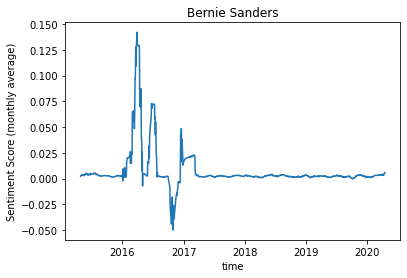

In [81]:
# Group sentiment scores by candidates and dates, average the score in each day
candidate_senti_byday = candidate_quotes_mention.groupby(['mention', 'date_only'])['normalize_quotation_score'].mean()
# Visualize the sentiment change of Bernie Sanders
candidate_senti_byday['BERNIE SANDERS'].rolling(window=30).mean().plot() # we take monthly average for better display
plt.xlabel('time')
plt.ylabel('Sentiment Score (monthly average)')
plt.title('Bernie Sanders')

We then look at the average sentiment toward each candidate within a year before the election. We can compare this to the final vote rate, so that we know whether the sentiment displayed in quotations reflect support rate.

In [82]:
# We group the quotations within 1 year before election day
quotes_byelection = candidate_quotes_mention[candidate_quotes_mention['date_only'] < candidate_quotes_mention['election_day']]
start_date = pd.to_datetime(quotes_byelection ['mention'].map(candidate_info_byname['year'] - 1).astype(str)+ '-11-01') # start date 1 yr before election
quotes_byelection = quotes_byelection[quotes_byelection['date_only'] > start_date] # all quotes within 1 year before election
# We compute the mean sentiment within that year
senti_byelection = pd.DataFrame(quotes_byelection.groupby(['mention'])['normalize_quotation_score'].mean())
senti_byelection.rename(columns = {'normalize_quotation_score': 'mean_sentiment_byelection'}, inplace=True)


Pearson coefficient: -0.10998685465657197, p value: 0.09323745970762687


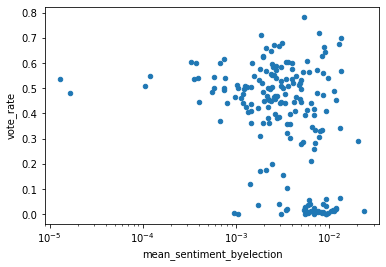

In [83]:
# We add the vote rate and plot the scatter plot of vote rate against total quotes by election
senti_byelection['vote_rate'] = senti_byelection.index.map(candidate_info_byname['vote_rate'])

# linear regression
senti_vote = senti_byelection.plot.scatter(x = 'mean_sentiment_byelection', y = 'vote_rate', logx=True)
(corr1, pvalue) = pearsonr(senti_byelection['mean_sentiment_byelection'], senti_byelection['vote_rate'])
print(f'Pearson coefficient: {corr1}, p value: {pvalue}')

There is no significant (p-value > 0.05) correlation between the sentiment in quotes and final vote rate!

## 3. Features for Prediction Model (This is the OLD CODE)
In the proposal, we decide to build a model predicting election results based on quotation data. Here, we preprocess the quote data and candidate data to generate the features for training our model.

The first feature is the change of quotation number over time. We will also use this for clustering analysis in proposed question 3.

In [ ]:
date_start=pd.to_datetime('2015-01-01', format='%Y-%m-%d') 
all_date = (pd.to_datetime('2020-12-31', format='%Y-%m-%d') - date_start).days # number of days.
candidate_quotes_name = candidate_quotes_byday.index.map(lambda x:x[0]).drop_duplicates()
candidate_quotes_feature = pd.DataFrame(np.zeros([all_date,len(candidate_quotes_name)]), columns=candidate_quotes_name) # initialize frequency vector

for candidate in candidate_quotes_name:
    candidate_mention = candidate_quotes_byday[candidate]
    for date in candidate_mention.index:
        date2days = (pd.to_datetime(date, format='%Y-%m-%d') - date_start).days # convert date to num of days w.r.t. start date
        candidate_quotes_feature[candidate].iloc[date2days] = candidate_mention.loc[date]

In [84]:
candidate_quotes_byday

speaker           date_only 
A. WAYNE JOHNSON  2015-01-06    0.601997
                  2015-02-09    0.602585
                  2015-02-11    1.205169
                  2015-02-20    0.602585
                  2015-03-01    0.535357
                                  ...   
ZAK RINGELSTEIN   2018-10-30    5.125275
                  2018-11-01    2.381878
                  2018-11-05    0.476376
                  2018-11-07    0.476376
                  2019-03-21    0.503878
Name: normalize_quotes, Length: 136070, dtype: float64

We also include the party affiliation of each candidate. Moreover, we also consider the affiliated party's vote rate in the most recent presidential election. Since we are looking at the election from 2016 to 2021, we will use the 2016 presidential election data for the senate election from 2016 to 2019, and use the 2020 presidential election data for the senate election from 2020 to 2021.

The presidential election data also comes from the MIT Election Data and Science Lab[2]. It contains the presidential election voting result by each state.

[2]MIT Election Data and Science Lab, 2017, "U.S. President 1976–2020", https://doi.org/10.7910/DVN/42MVDX, Harvard Dataverse, V6.

In [85]:
# We load 2016 and 2020 result separately
president = pd.read_csv('SenateData/1976-2020-president.csv')
president16 = president[president['year'] == 2016].copy()
president20 = president[president['year'] == 2020].copy()
president16.sample(4) #display format of president election data

,year,state,state_po,state_fips,state_cen,state_ic,office,candidate,party_detailed,writein,candidatevotes,totalvotes,version,notes,party_simplified
3432,2016,COLORADO,CO,8,84,62,US PRESIDENT,"TRUMP, DONALD J.",REPUBLICAN,False,1202484,2780220,20210113,NaN,REPUBLICAN
3652,2016,OKLAHOMA,OK,40,73,53,US PRESIDENT,"JOHNSON, GARY",LIBERTARIAN,False,83481,1452992,20210113,NaN,LIBERTARIAN
3636,2016,NORTH CAROLINA,NC,37,56,47,US PRESIDENT,SCATTERING,NaN,True,47386,4741564,20210113,NaN,OTHER
3534,2016,MAINE,ME,23,11,2,US PRESIDENT,NaN,UNENROLLED,False,2243,771892,20210113,NaN,OTHER


In [86]:
# We add vote rate to each candidate in each state
president16['vote_rate'] = president16['candidatevotes']/president16['totalvotes']
president20['vote_rate'] = president20['candidatevotes']/president20['totalvotes']

In [87]:
# We group the data by states and party_simplified (represent small parties, independent, NaN all by 'Others'). 
# We take sum of vote rates of cadidates from the same party_simplified
vote_byparty16 = president16.groupby(['state', 'party_simplified'])['vote_rate'].sum()
vote_byparty20 = president20.groupby(['state', 'party_simplified'])['vote_rate'].sum()
vote_byparty16

state      party_simplified
ALABAMA    DEMOCRAT            0.343579
           LIBERTARIAN         0.020942
           OTHER               0.014648
           REPUBLICAN          0.620831
ALASKA     DEMOCRAT            0.365509
                                 ...   
WISCONSIN  REPUBLICAN          0.472182
WYOMING    DEMOCRAT            0.216289
           LIBERTARIAN         0.051343
           OTHER               0.058384
           REPUBLICAN          0.673984
Name: vote_rate, Length: 201, dtype: float64

In [88]:
# We create feature dataframe and add in party_simplified, party vote rate in most recent presidential election, and final vote rate
# If the senate candidate's affiliated party does not show up in the most recent president election, party_vote_rate is 0
features = candidate_info_byname[['party_simplified', 'vote_rate']].copy()
for name in features.index:
    state_ = candidate_info_byname.loc[name, 'state']
    party_ = candidate_info_byname.loc[name, 'party_simplified']
    if candidate_info_byname.loc[name, 'year'] < 2020: #for candidate before 2020
        if party_ in vote_byparty16[state_].index:  #check whether the affiliated party is in recent president election
            features.loc[name, 'party_vote_rate'] = vote_byparty16[state_][party_]
        else: 
            features.loc[name, 'party_vote_rate'] = 0
    else:
        if party_ in vote_byparty20[state_].index: 
            features.loc[name, 'party_vote_rate'] = vote_byparty20[state_][party_]
        else: 
            features.loc[name, 'party_vote_rate'] = 0

# 4. statistics of sentence complexity (ALSO OLD Code)

We also calculated the average length of sentence and word of each quotation. This information may be used in our analysis about speech style (question 6).

In [89]:
# calculate average sentence length (by word number)
import re
candidate_quotes['split_quotation']=candidate_quotes.quotation.map(lambda x:re.split(r'\.|!|\?',x))
candidate_quotes['split_quotation']=candidate_quotes.split_quotation.map(lambda x:list(filter(None, x))) # remove empty string
candidate_quotes['avg_sentence_length'] = candidate_quotes.split_quotation.map(lambda x:np.mean(list(map(lambda s:len(s.split()), x))))
candidate_quotes.head(4)

,index,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,domains,normalize_factor,normalize_quotes,date_only,election_day,views,normalize_views,days_before_election,split_quotation,avg_sentence_length
0,0,2015-08-31-000271,... a great day for veterans here in Littleton...,JEANNE SHAHEEN,[Q270316],2015-08-31 02:10:00,2,"[[Jeanne Shaheen, 0.742], [None, 0.2359], [Kel...",[http://www.unionleader.com/article/20150831/N...,E,"[com, com]",0.473512,0.947023,2015-08-31,2020-11-01,1.350,0.639241,1889,[ a great day for veterans here in Littleton a...,21.500000
1,1,2015-10-25-000242,"' It is not now, nor has it ever been, the gol...",BERNIE SANDERS,[Q359442],2015-10-25 14:12:35,1,"[[Bernie Sanders, 0.5395], [None, 0.3128], [Hi...",[http://examiner.com/article/bernie-sanders-sl...,E,[com],0.416694,0.416694,2015-10-25,2018-11-01,0.675,0.281269,1103,"[' It is not now, nor has it ever been, the go...",24.333333
2,2,2015-11-13-000427,"[ My dad ] saw what a great opportunity it was,",PAUL STANTON,"[Q255668, Q27842994]",2015-11-13 08:45:01,1,"[[Paul Stanton, 0.6521], [None, 0.3479]]",[http://thecrimson.com/article/2015/11/13/paul...,E,[com],0.559562,0.559562,2015-11-13,2016-11-01,0.675,0.377704,354,"[[ My dad ] saw what a great opportunity it was,]",11.000000
3,3,2015-06-26-015863,hurt Michigan workers and cost thousands of Am...,GARY PETERS,"[Q1230954, Q1494930, Q5525742, Q56560036]",2015-06-26 22:31:05,1,"[[Gary Peters, 0.7907], [None, 0.2093]]",[http://detroitnews.com/story/news/politics/20...,E,[com],1.007044,1.007044,2015-06-26,2020-11-01,0.675,0.679755,1955,[hurt Michigan workers and cost thousands of A...,10.000000


In [33]:
# calculate average word lenghth for each quotation
candidate_quotes['split_words'] = candidate_quotes.quotation.map(lambda x:x.split())
candidate_quotes['avg_word_length'] = candidate_quotes.split_words.map(lambda x:np.mean(list(map(lambda w:len(w), x))))
candidate_quotes.head(4)

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,domains,date_only,election_day,split_quotation,avg_sentence_length,split_words,avg_word_length
0,2015-08-31-000271,... a great day for veterans here in Littleton...,JEANNE SHAHEEN,[Q270316],2015-08-31 02:10:00,2,"[[Jeanne Shaheen, 0.742], [None, 0.2359], [Kel...",[http://www.unionleader.com/article/20150831/N...,E,"[com, com]",2015-08-31,2020-11-01,[ a great day for veterans here in Littleton a...,21.500000,"[..., a, great, day, for, veterans, here, in, ...",4.318182
1,2015-10-25-000242,"' It is not now, nor has it ever been, the gol...",BERNIE SANDERS,[Q359442],2015-10-25 14:12:35,1,"[[Bernie Sanders, 0.5395], [None, 0.3128], [Hi...",[http://examiner.com/article/bernie-sanders-sl...,E,[com],2015-10-25,2018-11-01,"[' It is not now, nor has it ever been, the go...",24.333333,"[', It, is, not, now,, nor, has, it, ever, bee...",3.931507
2,2015-11-13-000427,"[ My dad ] saw what a great opportunity it was,",PAUL STANTON,"[Q255668, Q27842994]",2015-11-13 08:45:01,1,"[[Paul Stanton, 0.6521], [None, 0.3479]]",[http://thecrimson.com/article/2015/11/13/paul...,E,[com],2015-11-13,2016-11-01,"[[ My dad ] saw what a great opportunity it was,]",11.000000,"[[, My, dad, ], saw, what, a, great, opportuni...",3.363636
3,2015-06-26-015863,hurt Michigan workers and cost thousands of Am...,GARY PETERS,"[Q1230954, Q1494930, Q5525742, Q56560036]",2015-06-26 22:31:05,1,"[[Gary Peters, 0.7907], [None, 0.2093]]",[http://detroitnews.com/story/news/politics/20...,E,[com],2015-06-26,2020-11-01,[hurt Michigan workers and cost thousands of A...,10.000000,"[hurt, Michigan, workers, and, cost, thousands...",6.300000
